
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Авторы материала: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 (демо)
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [5]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [17]:
# Ваш код здесь
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

array([5, 5, 5, ..., 2, 2, 2])

Определим число уникальных значений меток целевого класса.

In [18]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [21]:
n_classes = np.unique(y).size
n_classes

6

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [42]:
# Ваш код здесь Преобразует значения признаков так, чтобы их среднее значение было равно 0, а стандартное отклонение - 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
# X_scaled.mean(axis=0)
# X_scaled.std(axis=0)

array([[ 2.10533854e-01, -6.87026385e-02, -4.52194533e-01, ...,
        -6.74432366e-01,  3.82007658e-01, -1.61505480e-02],
       [ 6.02084832e-02,  3.59023537e-02, -2.75221885e-01, ...,
        -6.81359801e-01,  3.83147865e-01, -1.20627169e-04],
       [ 7.84597052e-02, -4.64269585e-02, -8.55480582e-02, ...,
        -6.89470939e-01,  3.84288531e-01,  1.92144041e-02],
       ...,
       [ 1.11821625e+00,  1.28805864e+00, -1.29414692e-01, ...,
        -3.10750224e-01,  6.91509049e-01,  8.75719123e-01],
       [-5.43492722e-01,  9.75327452e-01,  2.34319837e-01, ...,
        -3.19283719e-01,  6.59762215e-01,  8.99444350e-01],
       [-1.78515253e+00, -1.86663622e-02, -5.29759691e-01, ...,
        -3.19991245e-01,  6.56994458e-01,  9.01454465e-01]])

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [50]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-16.38097982,   1.99508307,   3.41569023, ...,   0.34256962,
         -0.24397444,  -1.94678658],
       [-15.58217328,   1.18259368,  -0.32120675, ...,   0.13742091,
         -0.16081322,  -0.61432028],
       [-15.42398918,   2.24316643,  -1.23778356, ...,  -1.47098019,
         -1.24311139,   0.24672176],
       ...,
       [ 11.84685312,  -3.43356502,   2.18801926, ...,  -0.94467044,
         -0.34497972,  -2.09465647],
       [  8.20668637,  -4.38648876,   1.31871955, ...,   0.11723446,
         -1.32786056,   0.08742446],
       [  9.31117251,  -3.98616133,   1.93301747, ...,   0.12988206,
         -1.86396408,  -0.18253505]])

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [81]:
pca.explained_variance_ratio_.size

65

**Варианты:**
- 56 
- **65**
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- **51**
- 56
- 61

In [80]:
# Ваш код здесь
round(pca.explained_variance_ratio_[0]*100)

51

Визуализируйте данные в проекции на первые две главные компоненты.

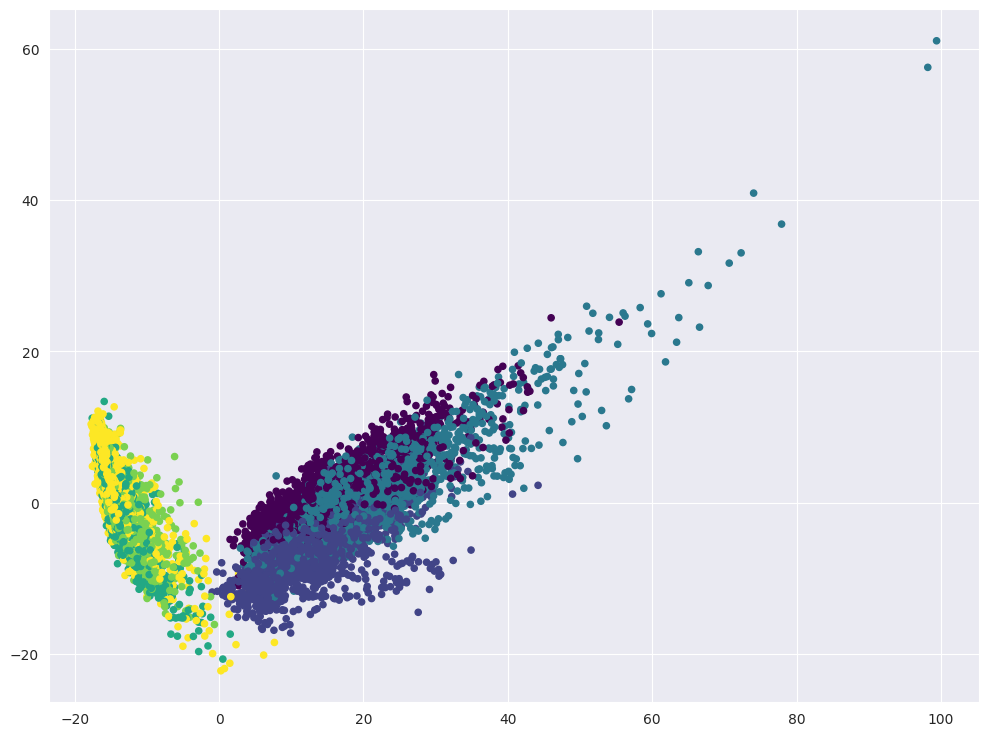

In [88]:
# Ваш код здесь
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='viridis');

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [216]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
X_kmeans = kmeans.fit(X_pca)
X_kmeans_transform = X_kmeans.transform(X_pca)
X_kmeans_transform
# X_kmeans
# X_kmeans.transform(X_pca) == kmeans.fit_transform(X_pca)

array([[-16.38097982,   1.99508307,   3.41569023, ...,   0.34256962,
         -0.24397444,  -1.94678658],
       [-15.58217328,   1.18259368,  -0.32120675, ...,   0.13742091,
         -0.16081322,  -0.61432028],
       [-15.42398918,   2.24316643,  -1.23778356, ...,  -1.47098019,
         -1.24311139,   0.24672176],
       ...,
       [ 11.84685312,  -3.43356502,   2.18801926, ...,  -0.94467044,
         -0.34497972,  -2.09465647],
       [  8.20668637,  -4.38648876,   1.31871955, ...,   0.11723446,
         -1.32786056,   0.08742446],
       [  9.31117251,  -3.98616133,   1.93301747, ...,   0.12988206,
         -1.86396408,  -0.18253505]])

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

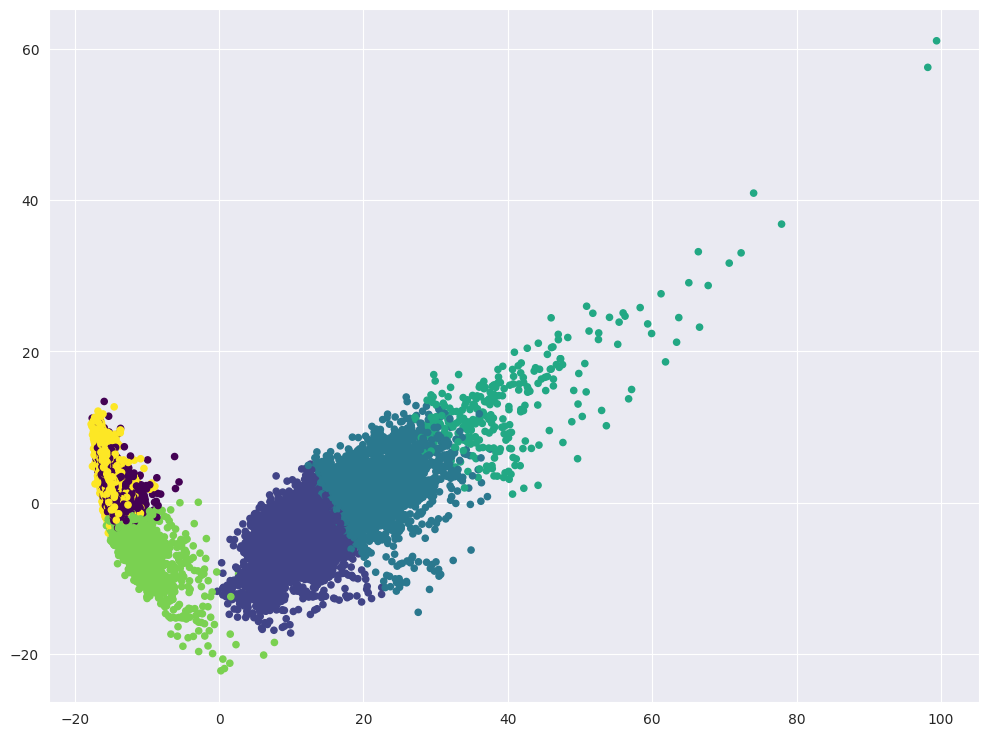

In [220]:
# Ваш код здесь
cluster_labels = kmeans.predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [181]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Лежание

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

C:\Users\zvina\AppData\Local\Temp\ipykernel_23192\4174703679.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

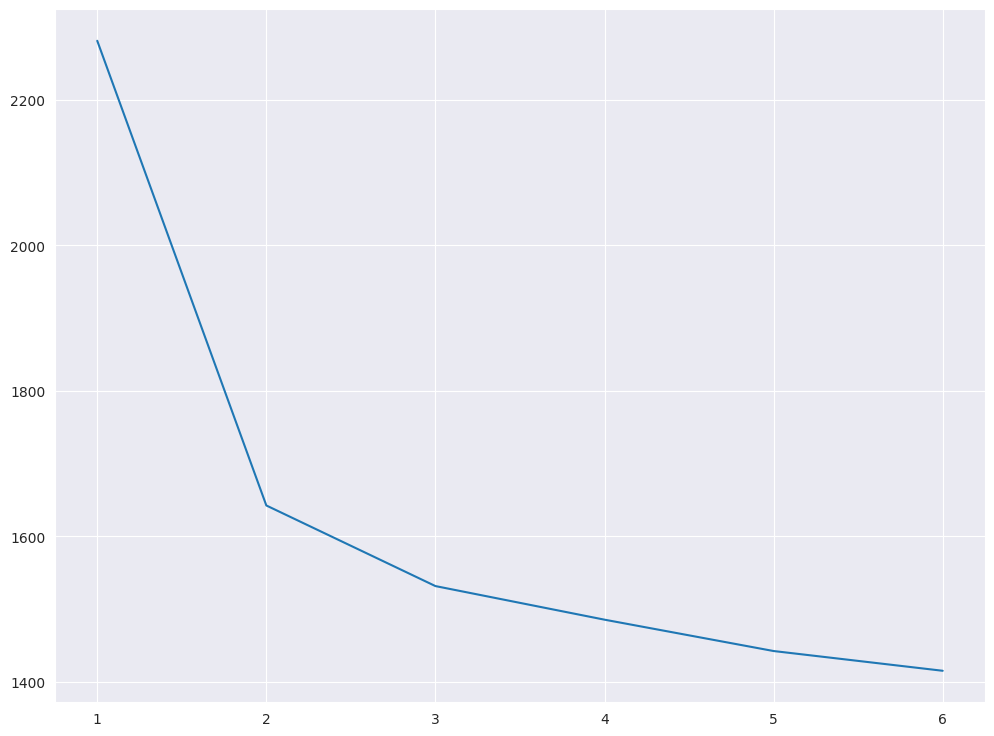

In [178]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans_lokot = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    X_kmeans_lokot = kmeans_lokot.fit(X_pca)
    inertia.append(np.sqrt(X_kmeans_lokot.inertia_))
    
plt.plot([1, 2, 3, 4, 5, 6], inertia)


**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- **3**
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [179]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [191]:
# Ваш код здесь
metrics.adjusted_rand_score(y, ag.labels_)

0.49362763373004886

In [193]:
metrics.adjusted_rand_score(y, kmeans.labels_)

0.4198070012602345

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

1.0 - правильное разбиение, 0 - случайные метки

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [221]:
# Ваш код здесь
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [195]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [213]:
# Ваш код здесь
grid = GridSearchCV(svc, svc_params, cv=3).fit(X_train_scaled, y_train)
best_svc = grid.best_estimator_
best_svc

C:\Users\zvina\PycharmProjects\recommendation_systems\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\zvina\PycharmProjects\recommendation_systems\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\zvina\PycharmProjects\recommendation_systems\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\zvina\PycharmProjects\recommendation_systems\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. S

LinearSVC(C=0.1, random_state=17)

In [204]:
# Ваш код здесь
best_svc.C

0.1

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [205]:
y_predicted = best_svc.predict(X_test_scaled)

In [209]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,6,531,537
все,484,482,421,453,574,533,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

предсказания - столбцы

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


In [210]:
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [211]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_2 = GridSearchCV(svc, param_grid=svc_params, cv=3).fit(X_train_scaled_pca, y_train)

C:\Users\zvina\PycharmProjects\recommendation_systems\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\zvina\PycharmProjects\recommendation_systems\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\zvina\PycharmProjects\recommendation_systems\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\zvina\PycharmProjects\recommendation_systems\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. S

In [214]:
round((grid.best_score_ - grid_2.best_score_) * 100)

4

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**